In [1]:
import ast

import networkx as nx
import pandas as pd
from gensim.models import KeyedVectors

In [2]:
df_op = pd.read_csv("/Users/elifozkan/Desktop/translator-openpredict/data/resources/openpredict-omim-drug.csv")

drug_fp_vectors = KeyedVectors.load_word2vec_format("/Users/elifozkan/Desktop/translator-openpredict/data/embedding/drugs_fp_embed.txt", binary=False)
disease_hp_vectors = KeyedVectors.load_word2vec_format(
    "/Users/elifozkan/Desktop/translator-openpredict/data/embedding/disease_hp_embed.txt", binary=False)

df_op = df_op.rename(columns={'omimid': 'disease_id', 'drugid': 'drug_id'})
df_op.disease_id = df_op.disease_id.astype(str)

indications_dict = set()
for i, row in df_op.iterrows():
    #row['DB_ID'], row['DO_ID']
    pair = (str(row['drug_id']), str(row['disease_id']))
    indications_dict.add(pair)

/Users/elifozkan/.pyenv/versions/3.8.13/lib/python3.8/site-packages/smart_open/smart_open_lib.py:400: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warnings.warn(


In [3]:
df_op["disease_id"].unique()

array(['231200', '155100', '273800', '607554', '171300', '102300',
       '137580', '147530', '601042', '608622', '161900', '143465',
       '144110', '261515', '276300', '188030', '148000', '273300',
       '236000', '254400', '114480', '607681', '239350', '190300',
       '600131', '607631', '604827', '608105', '208700', '607682',
       '300491', '217200', '607628', '267740', '210050', '208550',
       '600807', '151400', '258360', '109543', '126200', '603165',
       '151590', '133600', '125600', '164230', '167870', '115000',
       '134510', '134520', '134430', '227300', '134500', '157950',
       '254200', '300494', '181500', '178600', '247640', '102500',
       '215470', '601518', '311360', '176807', '192000', '137750',
       '145500', '225755', '608033', '260970', '225740', '215140',
       '256370', '600351', '203700', '208300', '137800', '267730',
       '254500', '540000', '125310', '601367', '150600', '166710',
       '602080', '167320', '607459', '208230', '308205', '1064

In [4]:
def calculateEntitySimilarities(tokenized_vector, topn = 100) :
    ''' calculates similarity scores of all drug-drug and disease-disease
        pairs that exist in the knowledge base
        return : a list containing all the similarity scores '''

    entities = list(tokenized_vector.vocab)
    similarity_scores = []
    for entity in entities :
        similarEntities = tokenized_vector.most_similar(entity, topn=100)
        for ent, sim in similarEntities :
            similarity_scores.append(1-sim)

    return similarity_scores

In [5]:
def getQuantiles( drug_vectors, disease_vectors, quantile = 0.1) :
    ''' calulcates the nth quantile of the calculated similarity scores
        return : the min-threshold for the drugs and diseases as a tuple
    '''
    drug_similarities = calculateEntitySimilarities(drug_vectors,505)

    drug_sim_df = pd.DataFrame(drug_similarities)
    #print(drug_sim_df.describe())

    disease_similarities = calculateEntitySimilarities(disease_vectors,309)

    disease_sim_df = pd.DataFrame(disease_similarities)
    return ((drug_sim_df.quantile(quantile)[0]), (disease_sim_df.quantile(quantile)[0]))

In [6]:

def percentiles_of_different_features():
    features_drug = ["TC", 'PPI_SIM', 'SE_SIM', 'GO_SIM', 'TARGETSEQ_SIM']
    features_diseases = ["HPO_SIM", 'PHENO_SIM']

    feature_percentiles = dict()
    for feature in features_drug :
        drug_emb = KeyedVectors.load_word2vec_format(
        'data/embedding/feature_specific_embeddings_KG/feature_FeatureTypesDrugs.' + str(feature) + '.txt', binary=False)
        calculateEntitySimilarities(drug_emb)
        dr,ds = getQuantiles(drug_emb, disease_hp_vectors,1)
        feature_percentiles[feature] = dr

    for feature in features_diseases :
        disease_emb = KeyedVectors.load_word2vec_format(
        'data/embedding/feature_specific_embeddings_KG/feature_FeatureTypesDiseases.' + str(feature) + '.txt', binary=False)
        calculateEntitySimilarities(disease_emb)
        dr,ds = getQuantiles(drug_fp_vectors, disease_emb,0.25)
        feature_percentiles[feature] = ds

    return feature_percentiles

In [7]:
def path_weight_summation(g1,drug,disease):
    path_weight = {}
    for path in nx.all_simple_paths(g1,"DRUGBANK:"+drug,"OMIM:"+disease, cutoff=4):
        dpath = 0
        for i in range(len(path)-1):
            dpath += g1[path[i]][path[i+1]]['weight']
        path_weight[str(path)] = dpath

    return path_weight


def path_weight_product(g1,drug,disease) :
    path_weight = {}
    for path in nx.all_simple_paths(g1,"DRUGBANK:"+drug,"OMIM:"+disease, cutoff=4):
        dpath = 0
        for i in range(len(path)-1):
            dpath *= g1[path[i]][path[i+1]]['weight']
        path_weight[str(path)] = dpath

    return path_weight

In [8]:
#functions which are used to generate the evidence path
def generate_paths_for_apair(drug, disease, drug_emb_vectors, disease_emb_vectors,features_drug = None, features_disease = None,threshold_drugs = 1,threshold_diseases = 1):
    g = nx.Graph()
    (threshold_drug,threshold_disease) =getQuantiles(drug_emb_vectors, disease_emb_vectors, threshold_drugs)

    if(features_drug is not None) :
         filtered_embedding_drugs = KeyedVectors.load_word2vec_format(f'{settings.OPENPREDICT_DATA_DIR}/evidence-path-model/feature_{str(features_drug)}.txt', binary=False)
         similarDrugs = filtered_embedding_drugs.most_similar(drug, topn=100)
         (threshold_drug,threshold_disease) =getQuantiles(filtered_embedding_drugs, disease_emb_vectors, threshold_drugs)
    else :
       similarDrugs = drug_emb_vectors.most_similar(drug, topn=100)


    g.add_node("DRUGBANK:"+drug, id="DRUGBANK:"+drug,
               name="fake", categories=["biolink:Drug"])
    for dr, sim in similarDrugs:
        if ((1-sim) <= threshold_drug) :
             g.add_node("DRUGBANK:"+dr, id="DRUGBANK:"+dr,
                   name="fake", categories=["biolink:Drug"])
             g.add_edge("DRUGBANK:"+dr, "DRUGBANK:"+drug, id="DRUGBANK:"+dr+"_DRUGBANK: "+drug,
                   predicate="biolink:similar_to", subject="DRUGBANK:"+dr, object="DRUGBANK:"+drug,  weight=1-sim, attributes={"description": "score",
                                                               "attribute_type_id": "EDAM:data_1772",
                                                               "value": (1-sim)                                                     })
             g.add_node("OMIM:"+disease, id="OMIM:"+disease,
               name="fake", categories=["biolink:Disease"])
    (threshold_drug,threshold_disease) =getQuantiles(drug_emb_vectors, disease_emb_vectors, threshold_diseases)


    # TODO: USE settings.OPENPREDICT_DATA_DIR instead of lucky relative path
    if(features_disease is not None) :
        filtered_embedding_diseases = KeyedVectors.load_word2vec_format('/Users/elifozkan/Desktop/translator-openpredict/data/evidence-path-model/feature_FeatureTypesDiseases.HPO_SIM.txt', binary=False)
        # filtered_embedding_diseases = KeyedVectors.load_word2vec_format(f'openpredict/data/embedding/feature_specific_embeddings_KG/feature_{str(features_disease)}.txt', binary=False)
        similarDiseases = filtered_embedding_diseases.most_similar(disease, topn=100)
        (threshold_drug,threshold_disease) =getQuantiles(drug_fp_vectors, filtered_embedding_diseases, threshold_diseases)
    else :
        similarDiseases = disease_emb_vectors.most_similar(disease, topn=100)


    for ds, sim in similarDiseases:
        if((1-sim) <= threshold_disease) :
             g.add_node("OMIM:"+ds, id="OMIM:"+ds,
                   name="fake", categories=["biolink:Disease"])
             g.add_edge("OMIM:"+ds, "OMIM:"+disease,
                   id="OMIM:" + ds+"_OMIM:"+disease, predicate="biolink:similar_to", subject="OMIM:"+ds, object="OMIM:"+disease, weight=1-sim, attributes={"description": "score",
                                                                                                 "attribute_type_id": "EDAM:data_1772",
                                                                                                 "value": 1+(1-sim)
                                                                                                 })

    for (dr, ds) in indications_dict:
        if "DRUGBANK:"+dr in g.nodes() and "OMIM:"+ds in g.nodes():
            g.add_edge("DRUGBANK:"+dr, "OMIM:"+ds, id="DRUGBANK:" +
                         dr+"_OMIM:"+ds, predicate="biolink:treats", subject="DRUGBANK:"+dr, object="OMIM:"+ds,  weight= 1.0,
                                                                                attributes={"description": "score",
                                                                               "attribute_type_id": "EDAM:data_1772",
                                                                               "value": "1.0"
                                                                               })

    return (g)

In [9]:
def generate_explanation(drug, disease, drug_fp_vectors, disease_hp_vectors,features_drug = None, features_disease = None,threshold_drugs = 0,threshold_disease = 0):
    #-> Path generation, add similar_to relation between query drug and disease
    #-> add known treats relations if any drug-disease pair in the graph has a treats relation
    g1= generate_paths_for_apair(
        drug, disease, drug_fp_vectors, disease_hp_vectors,features_drug, features_disease,threshold_drugs,threshold_disease)
    # Iterate over all simple paths
    # assign a weight to each path by summing their weights (for similar_to weight is 1-similarity, for treats, weight is 1)
    path_weight = path_weight_product(g1,drug=drug, disease=disease)
    # rank the paths and take only top-K paths
    path_weight_dict = sorted(path_weight.items(), key=lambda x: x[1], )
    # create a final graph by merging the top-K paths
    G = nx.Graph()
    for p, s in path_weight_dict[:100]:
        path = ast.literal_eval(p)
        for i in range(len(path)-1):
            s_node_name = path[i]
            t_node_name = path[i+1]
            edge_data = g1[s_node_name][t_node_name]

            G.add_node(s_node_name, id="DRUGBANK:"+drug,
               name="fake", categories=["biolink:Drug"])
            G.add_node(t_node_name, id="DRUGBANK:"+drug,
               name="fake", categories=["biolink:Drug"])

            G.add_edge(s_node_name, t_node_name, id = edge_data["id"], predicate= edge_data["predicate"],
            subject = edge_data["subject"], object = edge_data["object"], weight=edge_data["weight"],
            attributes= edge_data["attributes"])

    return G


In [10]:

def generate_json(graph) :
    graph_json ={}
    graph_json['nodes'] = list()

    for node in graph.nodes():
        graph_json['nodes'].append(graph[node])

    graph_json['edges']=list()
    for edge in graph.edges():
        graph_json['edges'].append(graph[edge[0]][edge[1]])

    return graph_json



def do_evidence_path(drug_id: str, disease_id: str, threshold_drugs : float,threshold_disease : float):
    ''' generates explanations based on the user input and returns a json'''
    evidence_path = generate_explanation(drug=drug_id, disease=disease_id, drug_fp_vectors = drug_fp_vectors, disease_hp_vectors= disease_hp_vectors,
                                         threshold_drugs = threshold_drugs,threshold_disease = threshold_disease )
    return evidence_path

### TO CREATE A KNOWLEDGE GRAPH VISUALIZATION WITH YOUR DESIRED DRUG AND DISEASE CHANGE VARIABLES drug and disease BELOW AND RUN ALL 


In [78]:
drug = 'DB00464'
disease = '231200'
evidence_path = do_evidence_path(drug, disease,0.60,0.55)

In [79]:
evidence_path.nodes

NodeView(('DRUGBANK:DB00464', 'DRUGBANK:DB00445', 'OMIM:114480', 'OMIM:231200', 'OMIM:276300', 'DRUGBANK:DB00444', 'OMIM:247640', 'DRUGBANK:DB00481', 'DRUGBANK:DB00399', 'DRUGBANK:DB00541', 'DRUGBANK:DB00286', 'OMIM:192200'))

In [80]:
import dgl
dgl_graph = dgl.from_networkx(evidence_path)
from dgl.data.utils import save_graphs
save_graphs("./evidence_path.bin", dgl_graph)

In [81]:
import matplotlib.patches as mpatches
color = ['lightgreen', 'darkorange', 'darkviolet']
label = ['Target Link', 'Compound', 'Disease']

In [82]:
edge_labels = {}
for edge in evidence_path.edges(): 
    if(edge[0].startswith("DB") & edge[1].startswith("DB")): 
        edge_labels[edge] = "similar_to"
    elif(edge[0].startswith("OMIM") & edge[1].startswith("OMIM")): 
        edge_labels[edge] = "similar_to"
    else:
        edge_labels[edge] = "treats"

In [83]:
node_color = []
for node in evidence_path.nodes:
        if ((drug in node) | (disease in node)): 
             node_color.append("lightgreen")
        elif node.startswith('DRUGBANK'):
            node_color.append('darkorange')
        elif node.startswith('OMIM'):
            node_color.append('darkviolet')

In [84]:
node_color

['lightgreen',
 'darkorange',
 'darkviolet',
 'lightgreen',
 'darkviolet',
 'darkorange',
 'darkviolet',
 'darkorange',
 'darkorange',
 'darkorange',
 'darkorange',
 'darkviolet']

In [85]:
edge_label_target = {("DRUGBANK:"+drug, "OMIM:"+disease):"Drug treats the disease"}

In [86]:
import matplotlib.pyplot as plt

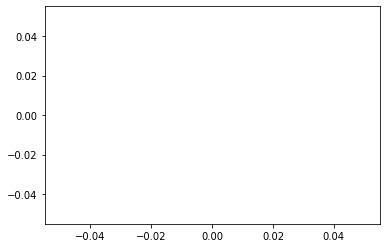

In [87]:
import matplotlib.patches as mpatches
color = ['orangered',  'darkorange', 'darkviolet']
label = ['Target Link', 'Compound', 'Disease']
patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=color[i], label="{:s}".format(label[i]))[0] for i in range(len(label))]

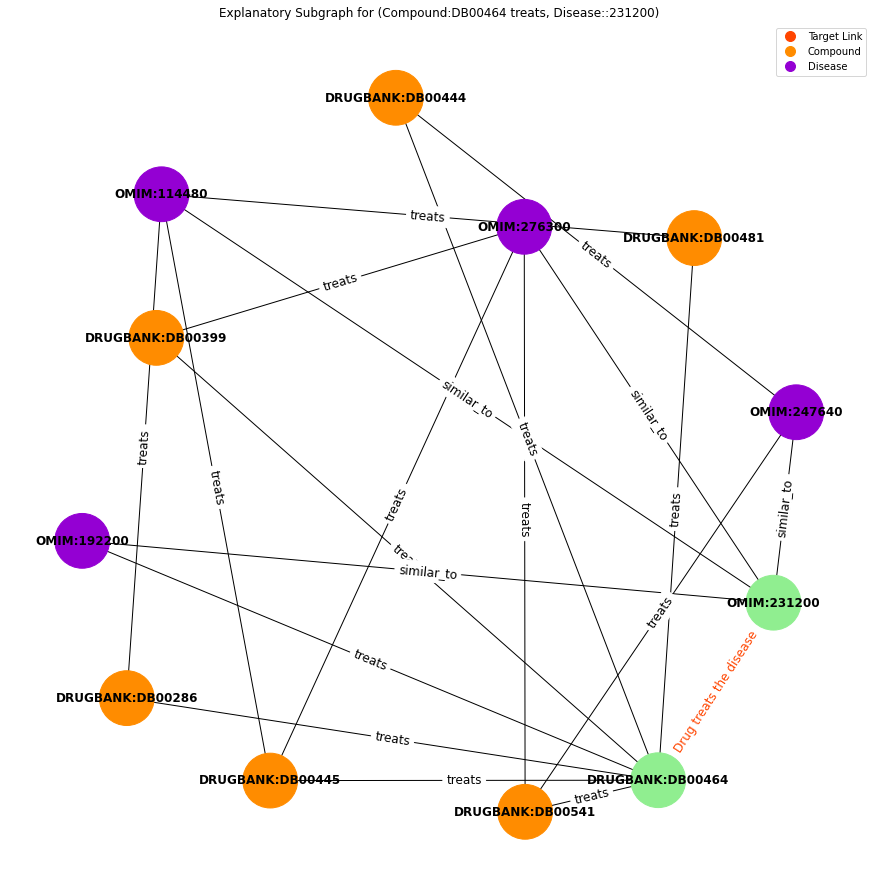

In [88]:

plt.figure(figsize = (12, 12))
pos = nx.spring_layout(evidence_path, k = 2.5)
nx.draw(evidence_path, with_labels=True, node_color=node_color, node_size=3000, pos=pos, font_weight='bold', font_size=12) #labels=labels)
nx.draw_networkx_edge_labels(evidence_path, pos, edge_labels=edge_labels, font_color='black', font_size=12)
nx.draw_networkx_edge_labels(evidence_path, pos, edge_labels=edge_label_target, font_color='orangered', font_size=12)
plt.title(f'Explanatory Subgraph for (Compound:{drug} treats, Disease::{disease})')
plt.legend(handles = patches)
plt.show()